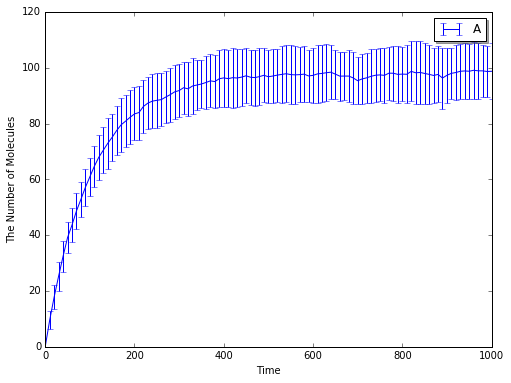

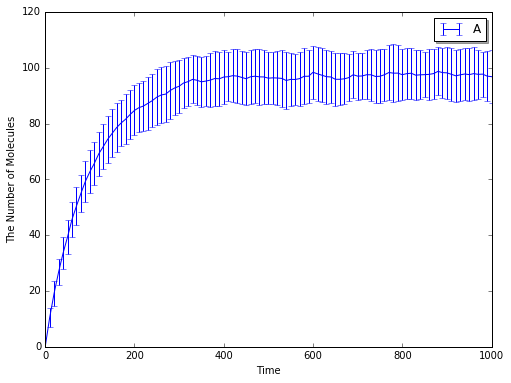

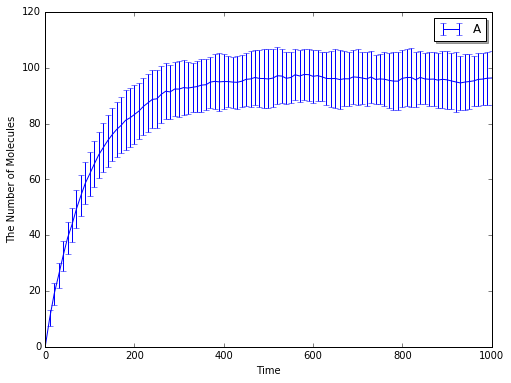

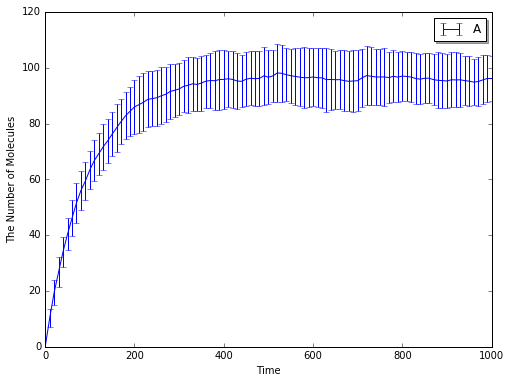

1 loop, best of 3: 16.4 s per loop


In [48]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import time

simrun=100
duration = 1000
L=2
V = L**3
rm = 0.05
D=0.1
wv=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)
kon= 1/wv
trials=1000
N=100
M = max(int(min(cbrt(N), L / (2 * rm))), 3)
#solver = ('egfrd', Integer3(M, M, M))
solver=("spatiocyte",rm)

with species_attributes():
    A | {'D': D, 'radius':rm}
with reaction_rules():
    ~A > A | kon
    A>~A |0.1*kon
m2 = get_model()
%timeit obs1=ensemble.ensemble_simulations(duration,n=simrun, model=m2, solver=solver,volume=V,species_list=["A"],return_type='matplotlib',nproc=3,method='multiprocessing')#,return_type="observer")


In [40]:
import multiprocessing

def genseeds(n):
    import binascii
    import os
    return binascii.hexlify(os.urandom(4 * n))

def singlerun(job, job_id, task_id):
    import ecell4.util
    import ecell4.extra.ensemble
    rndseed = ecell4.extra.ensemble.getseed(job.pop('myseed'), task_id)
    job.update({'return_type': 'array', 'rndseed': rndseed})
    data = ecell4.util.run_simulation(**job)
    return data

ecell4 implementation, using process and pipe

In [49]:
def run_multiprocessing(target, jobs, n=1, **kwargs):
    def target_wrapper(f, end_send):
        def wf(*_args, **_kwargs):
            end_send.send(f(*_args, **_kwargs))
        return wf

    processes = []
    end_recvs = []
    for i, job in enumerate(jobs):
        for j in range(n):
            end_recv, end_send = multiprocessing.Pipe(False)
            end_recvs.append(end_recv)
            p = multiprocessing.Process(
                target=target_wrapper(target, end_send), args=(job, i + 1, j + 1))
            p.start()
            processes.append(p)

    for p in processes:
        p.join()

    retval = [end_recv.recv() for end_recv in end_recvs]
    return [retval[i: i + n] for i in range(0, len(retval), n)]

jobs = [{'t': duration, 'y0': None, 'volume': V, 'model': m2, 'solver': solver, 'species_list': ["A"], 'structures': None, 'myseed': genseeds(simrun)}]

%timeit retval = run_multiprocessing(singlerun, jobs, n=simrun)


1 loop, best of 3: 15.8 s per loop


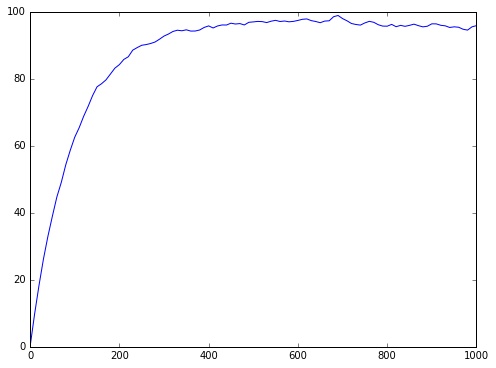

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
mean =np.mean( np.array(retval[0]),axis=0)
plt.plot(mean[:,0],mean[:,1])

using pool

In [50]:
job = {'t': duration, 'y0': None, 'volume': V, 'model': m2, 'solver': solver, 'species_list': ["A"], 'structures': None, 'myseed': genseeds(simrun)}

def runpool(func,n,kwargs):
    pool_size=multiprocessing.cpu_count()
    pool=multiprocessing.Pool(processes=pool_size)
    pool_out=[pool.apply_async(func,args=(kwargs,1,x+1)) for x in range(n)]
    pool.close()
    pool.join()
    return [p.get() for p in pool_out]

%timeit out =runpool(singlerun,simrun,job)


1 loop, best of 3: 15.1 s per loop


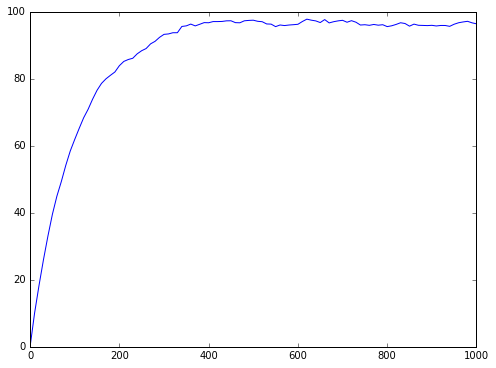

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
d=np.mean(np.array(out),axis=0)
plt.plot(d[:,0],d[:,1])